The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install -U --pre mxnet-cu101mkl  # updating mxnet to at least v1.6
!pip install git+https://github.com/d2l-ai/d2l-en # installing d2l


# Natural Language Inference: Fine Tuning BERT

*This section is under construction.*

![This section feeds pretrained BERT to an MLP-based architecture for natural
language inference.](../img/nlp-map-nli-bert.svg)

:label:`fig_nlp-map-nli-bert`

In [1]:
import d2l
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn

npx.set_np()
bert_batch_size, max_len = 512, 64
bert_train_iter, vocab = d2l.load_data_wiki(bert_batch_size, max_len)

MLM loss 6.786, NSP loss 0.692
8748.8 sentence pairs/sec on [gpu(0), gpu(1)]


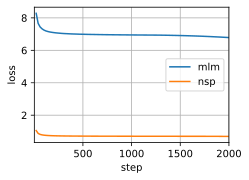

In [2]:
ctx, loss = d2l.try_all_gpus(), gluon.loss.SoftmaxCELoss()
bert = d2l.BERTModel(len(vocab), num_hiddens=256, ffn_num_hiddens=256,
                     num_heads=4, num_layers=2, dropout=0.2)
bert.initialize(init.Xavier(), ctx=ctx)
d2l.train_bert(bert_train_iter, bert, loss, len(vocab), ctx, 20, 2000)

...

In [3]:
class SNLIBERTDataset(gluon.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_tokens = d2l.tokenize(dataset[0])
        all_hypothesis_tokens = d2l.tokenize(dataset[1])
        self.labels = np.array(dataset[2])
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments,
         self.valid_lens) = self._preprocess(all_premise_tokens,
                                             all_hypothesis_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_premise_tokens, all_hypothesis_tokens):
        all_token_ids, all_segments, valid_lens = [], [], []
        for p_tokens, h_tokens in zip(
            all_premise_tokens, all_hypothesis_tokens):
            self._truncate_pair_of_tokens(p_tokens, h_tokens)
            tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
            all_token_ids.append(
                np.array(self.vocab[tokens] + [self.vocab['<pad>']]
                         * (self.max_len - len(tokens)), dtype='int32'))
            all_segments.append(
                np.array(segments + [0] * (self.max_len - len(segments)),
                         dtype='int32'))
            valid_lens.append(np.array(len(tokens)))
        return all_token_ids, all_segments, valid_lens 

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # Reserve slots for '<CLS>', '<SEP>', and '<SEP>' tokens for the
        # BERT input
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)

...

In [4]:
data_dir = d2l.download_extract('SNLI')
train_data = d2l.read_snli(data_dir, True)
test_data = d2l.read_snli(data_dir, False)
train_set = SNLIBERTDataset(train_data, max_len, vocab)
test_set = SNLIBERTDataset(test_data, max_len, vocab)

read 549367 examples


read 9824 examples


...

In [5]:
batch_size, num_workers = 512, d2l.get_dataloader_workers()
train_iter = gluon.data.DataLoader(train_set, batch_size, shuffle=True,
                                   num_workers=num_workers)
test_iter = gluon.data.DataLoader(test_set, batch_size,
                                  num_workers=num_workers)

...

In [6]:
class BERTClassifier(nn.Block):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.classifier = nn.Sequential()
        self.classifier.add(nn.Dense(256, activation='relu'))
        # There are 3 possible outputs: entailment, contradiction, and neutral
        self.classifier.add(nn.Dense(3))

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X, _, _ = self.bert(tokens_X, segments_X, valid_lens_x)
        return self.classifier(encoded_X[:, 0, :])

...

In [7]:
net = BERTClassifier(bert)
net.classifier.initialize(ctx=ctx)

...

loss 0.905, train acc 0.567, test acc 0.585
11501.0 examples/sec on [gpu(0), gpu(1)]


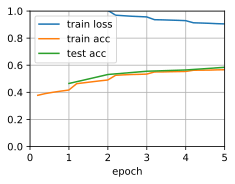

In [8]:
lr, num_epochs = 1e-4, 5
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
loss = gluon.loss.SoftmaxCrossEntropyLoss()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, ctx,
               d2l.split_batch_multi_inputs)

## Exercises

1. How to truncate a pair of sequences according to their ratio of length.